# Deep Learning
## Practice Projects
# P5: Decor Colorization

## Step 0. Style and Libraries
Let's choose a style of the Jupyter notebook and import the software libraries. The command hide_code will hide the code cells.

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                  

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

Using TensorFlow backend.


In [3]:
hide_code
# Plot the neural network fitting history
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

## Step 1. Load and Explore the Data
For this project, I have created the dataset of color images (150x150x3) with traditional patterns. Run the following cells to download the data.

In [4]:
hide_code
# Function for processing an image
def image_to_tensor(img_path, folder_path):
    img = keras_image.load_img(folder_path + img_path, target_size=(150, 150))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths, folder_path):
    list_of_tensors = [image_to_tensor(img_path, folder_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [37]:
hide_code
# Load the dataset 
data = pd.read_csv("decor.txt")
files = data['file']

countries = data['country_label'].as_matrix()
decors = data['decor_label'].as_matrix()
types = data['type_label'].as_matrix()

images = data_to_tensor(files, "data/");

100%|██████████| 262/262 [00:04<00:00, 61.02it/s]


In [38]:
hide_code
# Print the shape 
print ('Image shape:', images.shape)
print ('Country shape:', countries.shape)
print ('Decor shape:', decors.shape)
print ('Type shape:', types.shape)

Image shape: (262, 150, 150, 3)
Country shape: (262,)
Decor shape: (262,)
Type shape: (262,)


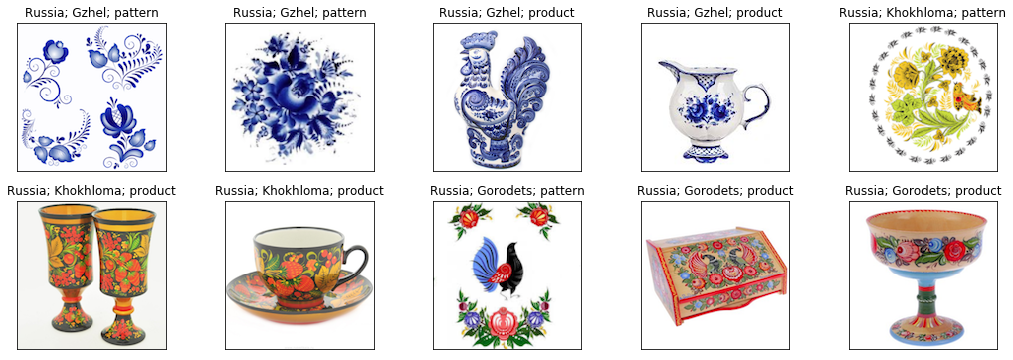

In [39]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[], 
                         title=data['country'][i*26]+'; '+data['decor'][i*26]+'; '+data['type'][i*26])
    display_images(files[i*26], ax)

## Step 2. Save and Load the Data
The data tensors can be saved in the appropriate format of files .h5.

In [40]:
hide_code
# Create the tensor file
with h5py.File('DecorColorImages.h5', 'w') as f:
    f.create_dataset('images', data = images)
    f.create_dataset('countries', data = countries)
    f.create_dataset('decors', data = decors)
    f.create_dataset('types', data = types)
    f.close()

In [41]:
hide_code
# Read the h5 file
f = h5py.File('DecorColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['countries', 'decors', 'images', 'types']

In [42]:
hide_code
# Create tensors and targets
countries = np.array(f[keys[0]])
decors = np.array(f[keys[1]])
images = np.array(f[keys[2]])
types = np.array(f[keys[3]])

print ('Image shape:', images.shape)
print ('Country shape:', countries.shape)
print ('Decor shape:', decors.shape)
print ('Type shape:', types.shape)

Image shape: (262, 150, 150, 3)
Country shape: (262,)
Decor shape: (262,)
Type shape: (262,)


## Step 3. Implement Preprocess Functions

In [43]:
hide_code
# Normalize the tensors
images = images.astype('float32')/255

Country:  1 - Russia
Decor:  1 - Gzhel
Type:  2 - product


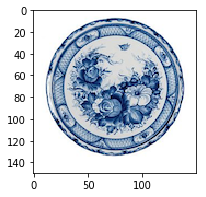

In [44]:
hide_code
# Read and display a tensor using Matplotlib
print('Country: ', countries[75], '-', data['country'][75])
print('Decor: ', decors[75], '-', data['decor'][75])
print('Type: ', types[75], '-', data['type'][75])
plt.figure(figsize=(3,3))
plt.imshow(images[75]);

In [45]:
hide_code
# Grayscaled tensors
gray_images = np.dot(images[...,:3], [0.299, 0.587, 0.114])
print ("Shape of grayscaled images:", gray_images.shape)

Shape of grayscaled images: (262, 150, 150)


Country:  1 - Russia
Decor:  1 - Gzhel
Type:  2 - product


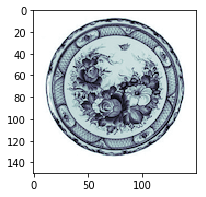

In [46]:
hide_code
# Read and display a grayscaled tensor using Matplotlib
print('Country: ', countries[75], '-', data['country'][75])
print('Decor: ', decors[75], '-', data['decor'][75])
print('Type: ', types[75], '-', data['type'][75])
plt.figure(figsize=(3,3))
plt.imshow(gray_images[75], cmap=cm.bone);

In [47]:
hide_code
# Print the target unique values
print('Countries: ', set(countries))
print('Decors: ', set(decors))
print('Types: ', set(types))

Countries:  {1}
Decors:  {1, 2, 3}
Types:  {1, 2}


In [48]:
# One-hot encode the targets, started from the zero label
cat_countries = to_categorical(np.array(countries-1), 5)
cat_decors = to_categorical(np.array(decors-1), 10)
cat_types = to_categorical(np.array(types-1), 2)
cat_countries.shape, cat_decors.shape, cat_types.shape

((262, 5), (262, 10), (262, 2))

In [49]:
# Create multi-label targets
targets = np.concatenate((cat_countries, cat_decors), axis=1)
targets = np.concatenate((targets, cat_types), axis=1)
targets.shape

(262, 17)

In [50]:
hide_code
# Split the data / Color images
x_train, x_test, y_train, y_test = train_test_split(images, targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [51]:
hide_code
# Split the data / Grayscaled images
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_images, targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test2)/2)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

In [52]:
hide_code
# Reshape the grayscaled data
x_train2, x_test2, x_valid2 = \
x_train2.reshape(-1, 150, 150, 1), x_test2.reshape(-1, 150, 150, 1), x_valid2.reshape(-1, 150, 150, 1)

## Step 4. Create a Neural Network